# SLOPE for Count Data

*Authors: Zachary Lau, Joey Hotz and Javier Martinez-Rodriguez*

## Introduction

Sorted L-One Penalized Estimation (SLOPE) is a regression model characterized by the penalization $\sum_{i=1}^{p} \lambda_i |\beta|_{(i)}$, where the penalty parameters $\lambda_i$ are non-increasing and depend on the rank of the coefficient magnitudes (Bogdan et al. 2015). This design offers finite sample guarantees for the selected model. In particular the Benjamini-Hochberg (BH) inspired sequence of $\lambda_i$ sequence provides theoretical control over the False Discovery Rate (FDR) for Gaussian linear models.

In the context of generalized linear models (GLMs), particularly in Poisson regression, this topic has not been discussed. Therefore, this project aims to empirically evaluate and compare the variable selection performance of SLOPE. The central research question is: How does the performance of SLOPE regarding variable selection accuracy (FDR and Power) compare to LASSO and Adaptive LASSO when applied to high-dimensional Poisson regression? To address this question, the project employs simulations to compare the variable selection accuracy (measured by FDR and Power) of SLOPE against standard and adaptive LASSO across different scenarios varying in predictor dimensionality ($p/n$ ratio), inter-predictor correlation ($\rho$), sparsity ($k$) and signal strength.

This document is organized into three parts. First, it provides a general explanation of SLOPE applied to Gaussian linear models and the effect of choosing different procedures to assign its values, as discussed by Bogdan et al. (2015). In particular, it discusses the FDR provided by the Benjamini-Hochberg procedure. Second, the implementation of SLOPE in Generalized Linear Models (GLM) is addressed, particularly with count data, as proposed by Larsson et al. (2024). Third, the simulation settings, competing penalizations, and results are discussed.



## Methods and Results
### Model Selection and SLOPE

SLOPE extends the LASSO penalty by introducing a sequence of non-increasing regularization parameters, resulting in the optimization problem 
$$\min \frac 1 2 \|y-X\beta\|^2 + \sigma \cdot \sum_{i=1}^p \lambda_{i} |\beta|_{(i)},$$
where $|\beta|_{(1)} \ge |\beta|_{(2)} \ge \dots \ge |\beta|_{(p)}$ are sorted in descending order and the sequence $\lambda_1 \ge \lambda_2 \ge \dots \ge \lambda_p \ge 0$ provides non-increasing penalization parameters (Bogdan et al. 2015, 1109). SLOPE generalizes LASSO and reduces to it if all $\lambda_i = \lambda$.

In comparison to the LASSO estimator of Tibshirani (1996), SLOPE applies larger penalties $\lambda_i$ to coefficients with larger magnitudes. The motivation for doing this is to provide finite sample guarantees on the selected model. According to Bogdan et al. (2015), variable selection can be interpreted as multiple hypothesis testing ($H_{0j}: \beta_j = 0$). While LASSO weakly controls the familywise error rate (FWER) at level $\alpha \in [0, 1]$ under an orthogonal design ($X^TX=I_p$) by setting $\lambda = \sigma \Phi^{-1}(1-\alpha/(2p))$ (Abramovich, Grinshtein and Pensky 2007), SLOPE is designed to control the FDR under an orthogonal design.

In order to control the FDR, the authors propose choosing the $\lambda_i$ sequence based on BH critical values
. This connection is often solidified by choosing the $\lambda_i$ sequence based on BH critical values. In the case of the Gaussian model and orthogonal designs, it is
$$\lambda_i = \sigma \Phi^{-1}\left(1 - \frac{q \cdot i}{2p}\right),$$
where $\sigma$ is the noise standard deviation (often assumed known), $\Phi^{-1}$ is the standard normal quantile function, $q$ is the target FDR level, $p$ is the number of predictors, and $i$ is the rank. While related, SLOPE is not identical to BH testing; it remains a convex optimization problem.

### Explanation of SLOPE for Count Data

The theory of SLOPE can easily be extended to GLM's. In particular, we focus on
finding the analagous Benjamini-Hochberg coefficients in the case of a GLM.
Recall the pdf of an exponential family model is given by 
$$ f(y) = \exp\left(\frac{y\eta - b(\eta)}{a(\phi)}+c(y,\phi)\right)$$

When using the canonical link, $\eta = \mathbf{X}^\top\beta$, so we may write

$$f(y) = \exp\left(\frac{yX^\top\beta - b(X^\top \beta)}{a(\phi)}+c(y,\phi)\right)$$

In this case, we may find the MLE $\hat\beta$ numerically. Under appropriate
regularity conditions, it has asymptotic distribution 

$$ \sqrt{n}(\hat\beta-\beta) \leadsto \mathcal N(0, \mathcal I^{-1}(\beta))$$

Where $\mathcal I(\beta)$ is the expected Fisher information. For the
exponential family it is given by

$$\frac{1}{a(\phi)} \mathbf{X}^\top \text{diag}(b''(\mathbf{X}\beta))\mathbf{X}$$

We make two simplifications to this expression
- As is done by Bogdan et. al in their seminal work on SLOPE, we consider the
case of an orthogonal design matrix $X$
- We consider the distribution under the omnibus null hypothesis, that is 
$\beta = \vec 0$

This second assumption is perhaps the most dubious, and we will revist it later.
Nevertheless, under these simplifications we find that the Fisher information
simplifies to 

$$ \mathcal I(\beta) = \frac{b''(0)}{a(\phi)}\mathbf I $$

Thus under $H0: \beta = \vec 0$, the coefficient estimates are independent
and identically distributed with variance $\frac{a(\phi)}{b''(0)}$. For the
Poisson model in particular, we have
- $a(\phi) = 1$
- $b''(0) = 1$

Using the Benjamini-Hochberg method as in Bogdan et al. this gives BH-inspired
slope coefficients of
$$\lambda_j = \sqrt{\frac{b''(0)}{a(\phi)}}\phi^{-1}\left(1-\frac{qj}{2m}\right)$$

In the Poisson case in particular we get 

$$\lambda_j = \phi^{-1}\left(1-\frac{qj}{2m}\right)$$

### Experiments

#### Competing Penalizations

The LASSO penalty is defined as $\lambda \|\boldsymbol{\beta}\|_1 = \lambda \sum_{j=1}^{p} |\beta_j|$, where $\lambda \ge 0$ is a single tuning parameter that regulates the strength of the penalty (Tibshirani 1996). As previously discussed, Bonferroni-inspired penalization of LASSO provides control over FWER. however, this extension does not apply to non-Gaussian GLMs. For this reason, our project only compares LASSO tuned through cross-validation.

The Adaptive LASSO, proposed by Zou (2006), modifies the standard LASSO penalty by incorporating adaptive weights for each coefficient $\lambda \sum_{j=1}^{p} w_j |\hat{\beta}_j|$. These weights $w_j$ are determined from an initial consistent estimate of the coefficients $w_j \propto 1/|\hat{\beta}_{init, j}|^{-\gamma}$. The motivation for these weights is to assign smaller penalties to coefficients with large initial estimates while imposing larger penalties on those with smaller initial estimates.

Due to its design, Zou (2006, 1424) showed that the oracle properties of Adaptive LASSO can be extended to GLMs under mild regularity conditions. This indicates that the estimator asymptotically behaves as if the true underlying model is known in advance, this method correct identification of the true set of non-zero coefficients with a probability approaching 1 as the sample size $n \rightarrow \ infty$. Consequently, this method serves as a benchmark for comparing the variable selection capabilities of Poisson SLOPE.

Other methodologies, including Data Splitting, Multiple Data Splitting (MDS), model-X knockoff, and Gaussian mirror have been shown to effectively control FDR for GLMs. However, these approaches will not be addressed in this project. 


#### Experimental Settings (212 words)

To compare the variable selection performance of SLOPE against LASSO and Adaptive LASSO for high-dimensional data, count data is generated following a Poisson distribution with a log-linear link given by $\log(\lambda_i) = \beta_0 + X_i \beta$. The comparison is measured in terms of FDR and Power across 50 replications to ensure statistical stability. Performance is assessed using SLOPE tuned to a target FDR of $q=0.1$ via a BH-inspired $\lambda$ sequence using 10-fold cross-validation, while LASSO and Adaptive LASSO tune $\lambda$ using 10-fold cross-validation minimizing Poisson deviance.

The chosen experimental settings are conditions to challenge variable selection. The dimensionality cases include scenarios where predictors outnumber observations, are equal and are fewer ($p \in \{500, 1000, 2000\}$ with $n=1000$). Predictor correlation is evaluated with none, medium, and high correlation ($\rho \in \{0, 0.5, 0.8\}$). This is particularly relevant since correlation among regressors introduces complications in the selection of variables.

The underlying sparsity level ($k \in \{10, 20, 50, 100\}$ active predictors) is evaluated at different levels to see how methods cope as the number of true signals increases relative to the total predictors. Finally, simulating both "Weak" and "Strong" signal strengths (magnitudes of non-zero $\beta_j$) tests the Power of each method to detect subtle versus obvious effects. The code below implements the generative model for the discussed settings. 

In [ ]:
# Setup ----
## Packages to use ----
if (!require("pacman")) install.packages("pacman")
# if (!require("mytidyfunctions")) remotes::install_github("JavierMtzRdz/mytidyfunctions")

pacman::p_load(tidyverse, janitor, 
               SLOPE, glmnet, MASS,
              # mytidyfunctions,
               progress,
               patchwork, here)

## Load fonts ----
extrafont::loadfonts(quiet = TRUE)

## Set theme ------
# mytidyfunctions::set_mytheme(text = element_text(family = "Lato"))


In [2]:
# Generative models
## Simulation Parameters
n <- 5000         
p_values <- c(500, 1000, 2000) 
rho_values <- c(0, 0.5, 0.8)  
k_values <- c(10, 20, 50, 100) # Non-zero betas
signal_strengths <- list( 
  weak = list(beta_min = 0.1, beta_max = 0.5),
  strong = list(beta_min = 0.5, beta_max = 1.5)
)
R <- 1 
q_fdr <- 0.1       # q parameter for SLOPE
adapt_lasso_gamma <- 1 # ALasso weights
beta0 <- 0.5

set.seed(538)

## Generative model
generate_data <- function(n, p, rho, k, signal_info, beta0) {

  beta_true <- numeric(p)

  if (k > 0) {
    non_zero_indices <- sample(1:p, k)
    magnitudes <- runif(k, min = signal_info$beta_min, max = signal_info$beta_max)
    signs <- sample(c(-1, 1), k, replace = TRUE)
    beta_true[non_zero_indices] <- magnitudes * signs
  }
  true_support <- which(beta_true != 0)

  # Generate X
  Sigma <- matrix(rho, nrow = p, ncol = p)
  diag(Sigma) <- 1
  X <- MASS::mvrnorm(n = n, mu = rep(0, p), Sigma = Sigma)
  X <- scale(X)

  # Count response 
  lambda <- exp(beta0 + X %*% beta_true)
  # lambda <- pmin(lambda, some_large_value)
  y <- rpois(n, lambda)

  return(list(X = X, y = y, beta_true = beta_true, true_support = true_support, beta0 = beta0, lambda = lambda))
}

In [12]:
# Function to calculate FDR and Power
calculate_metrics <- function(selected_indices, true_indices, p) {
  true_positives <- length(intersect(selected_indices, true_indices))
  false_positives <- length(setdiff(selected_indices, true_indices))
  # Power
  power <- ifelse(length(true_indices) == 0, NA, true_positives / length(true_indices))
  # FDR
  fdr <- ifelse((true_positives + false_positives) == 0, 0, false_positives / (true_positives + false_positives))
  return(list(FDR = fdr, Power = power, TP = true_positives, FP = false_positives, Selected_Count = length(selected_indices)))
}

In [ ]:
# Loop ---

results_list <- list()
total_runs <- length(p_values) * length(rho_values) * length(k_values) * length(signal_strengths) * R
cli::cli_progress_bar("Cleaning data", total = total_runs)
iter <- 0

for (p in p_values) {
  for (rho in rho_values) {
    for (k in k_values) {
      for (signal_name in names(signal_strengths)) {
        signal_info <- signal_strengths[[signal_name]]

        for (rep in 1:R) {
          cli::cli_progress_update()
          iter <- iter + 1

          # Generate Data
          sim_data <- generate_data(n = n, p = p, rho = rho, k = k,
                                    signal_info = signal_info, beta0 = beta0)
          X <- sim_data$X
          y <- sim_data$y
          lambda_val <- sim_data$lambda
          true_beta <- sim_data$true_support # Indices of non-zero elements in beta_true
          true_support <- which(abs(true_betaa) > 1e-6)
          # Models

          # SLOPE
          selected_slope <- integer(0) # Initialize as empty
          fdr_slope <- NA
          power_slope <- NA
          slope_error <- FALSE
          slope_fit <- SLOPE::SLOPE(X, y, family = "poisson", q = q_fdr, lambda = "bh", alpha = 1 / sqrt(n))
          slope_coeffs <- coef(slope_fit)

          selected_slope <- which(slope_coeffs[-1] != 0)
          metrics_slope <- calculate_metrics(selected_slope, true_support, p)
          fdr_slope <- metrics_slope$FDR
          power_slope <- metrics_slope$Power


          # LASSO 
          selected_lasso <- integer(0)
          fdr_lasso <- NA
          power_lasso <- NA
          lasso_error <- FALSE
          cv_lasso_fit <- cv.glmnet(X, y, family = "poisson", alpha = 1, standardize = FALSE)
          lasso_coeffs <- coef(cv_lasso_fit, s = "lambda.min")
          selected_lasso <- which(lasso_coeffs[-1] != 0) 
          metrics_lasso <- calculate_metrics(selected_lasso, true_support, p)
          fdr_lasso <- metrics_lasso$FDR
          power_lasso <- metrics_lasso$Power


          # Adaptive LASSO
          selected_adapt <- integer(0)
          fdr_adapt <- NA
          power_adapt <- NA
          adapt_error <- FALSE

          cv_ridge_fit <- cv.glmnet(X, y, family = "poisson", alpha = 0, standardize = FALSE) 
          ridge_coeffs <- coef(cv_ridge_fit, s = "lambda.min")[-1] 

          # Calculate weights 
          weights <- 1 / (abs(ridge_coeffs) + .Machine$double.eps)^adapt_lasso_gamma
          weights <- pmin(weights, 1e10) 

          # Fit weighted LASSO using CV
          cv_adapt_fit <- cv.glmnet(X, y, family = "poisson", alpha = 1,
                                      penalty.factor = weights, standardize = FALSE)
          adapt_coeffs <- coef(cv_adapt_fit, s = "lambda.min")
          selected_adapt <- which(adapt_coeffs[-1] != 0) 
      
          metrics_adapt <- calculate_metrics(selected_adapt, true_support, p)
          fdr_adapt <- metrics_adapt$FDR
          power_adapt <- metrics_adapt$Power

          # Save results
          results_list[[iter]] <- data.frame(
            n = n, p = p, rho = rho, k = k, signal = signal_name, replication = rep,
            Method = c("SLOPE", "LASSO", "AdaptiveLASSO"),
            FDR = c(fdr_slope, fdr_lasso, fdr_adapt),
            Power = c(power_slope, power_lasso, power_adapt),
            SelectedCount = c(length(selected_slope), length(selected_lasso), length(selected_adapt))
          )

        }}}}} 
cli::cli_progress_done()

final_results <- bind_rows(results_list)

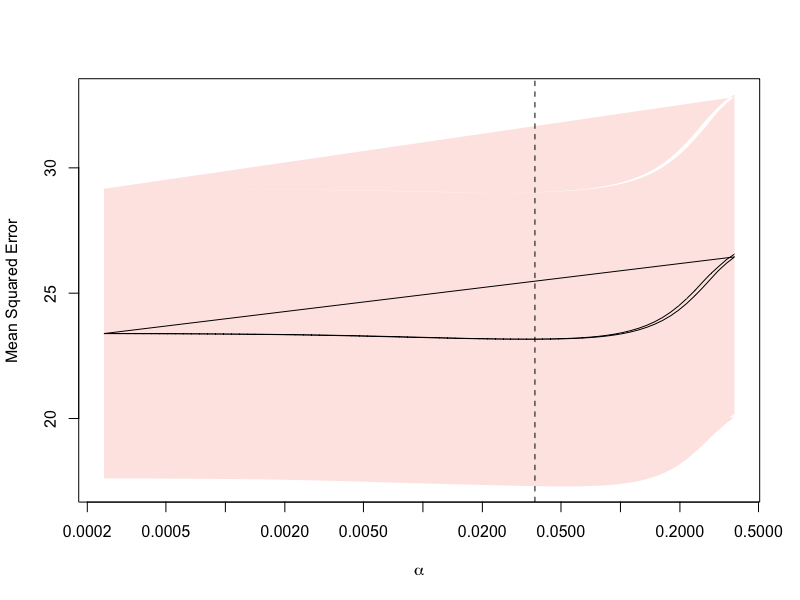

NULL

In [6]:
slope_fit <- SLOPE::trainSLOPE(X, y, family = "poisson", q = c(0.1, 0.2))
slope_coeffs <- coef(slope_fit)
plot(slope_fit) +
  guides(color = "none")

In [7]:
slope_fit


Call:
SLOPE::trainSLOPE(x = X, y = y, q = c(0.1, 0.2), family = "poisson")

Optimum values:
    q      alpha measure      mean         se        lo       hi
1 0.2 0.14898190     mae  2.332161 0.05293994  2.212403  2.45192
2 0.2 0.03690395     mse 23.164729 2.59083817 17.303846 29.02561

In [68]:
n <- 1000
p <- n / 2
data <- SLOPE:::randomProblem(n = n, p = 1000, q = 0.3, response = "gaussian", alpha = 1)
X <- data$x
y <- data$y
true_support <- which(abs(data$beta) > 1e-6)

In [73]:
fit <- SLOPE(X,
  y,
  lambda = "gaussian",
  solver = "admm",
  q = 0.1,
  alpha = 1 / sqrt(n)
)

selected_slope <- which(fit$nonzeros)
V <- length(setdiff(selected_slope, signals))
R <- length(selected_slope)

slope_coeffs <- coef(fit)
selected_slope <- which(slope_coeffs[-1] != 0)
true_support <- which(abs(problem$beta) > 1e-6)
calculate_metrics(selected_slope, true_support, 500)
V/R

[1] 0.75

In [6]:
SLOPE:::randomProblem

function (n = 1000, p = 100, q = 0.2, n_groups = NULL, n_targets = if (match.arg(response) == 
    "multinomial") 3 else 1, density = 1, amplitude = if (match.arg(response) == 
    "poisson") 1 else 3, alpha = 1, response = c("gaussian", 
    "binomial", "poisson", "multinomial"), rho = 0) 
{
    m <- n_targets
    if (density == 1) {
        x <- matrix(stats::rnorm(n * p), n)
    }
    else {
        x <- Matrix::rsparsematrix(n, p, density)
    }
    if (rho > 0) {
        x <- sqrt(1 - rho) * x + sqrt(rho) * stats::rnorm(n)
    }
    if (!is.null(n_groups)) {
        groups <- rep(seq_len(n_groups), each = ceiling(m * p/n_groups), 
            length.out = p * m)
        nonzero <- which(groups %in% seq_len(max(floor(n_groups * 
            q), 1)))
    }
    else {
        groups <- NA
        nonzero <- sample(p * m, max(floor(q * p * m), 1))
    }
    signs <- sample(c(-1, 1), p * m, replace = TRUE)
    beta <- signs * amplitude * (1:(p * m) %in% nonzero)
    y <- switch(match.a

In [8]:
final_results <- bind_rows(results_list)
final_results

: [1m[33mError[39m in `bind_rows()`:[22m
[33m![39m could not find function "bind_rows"

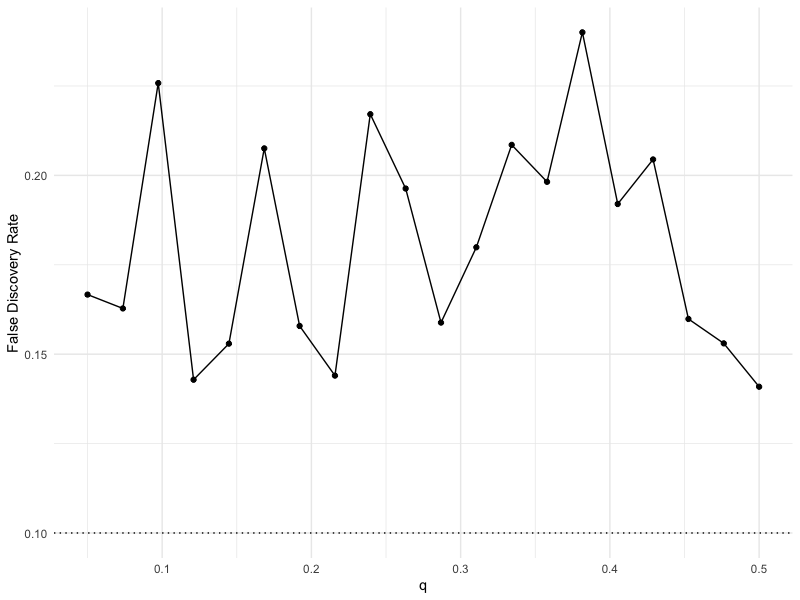

In [77]:
pacman::p_load(SLOPE)
# proportion of real signals
q <- seq(0.05, 0.5, length.out = 20)
fdr <- double(length(q))
set.seed(1)

for (i in seq_along(q)) {
  n <- 1000
  p <- n / 2
  alpha <- 1
  problem <- SLOPE:::randomProblem(n, p, q = q[i], alpha = alpha)

  x <- problem$x
  y <- problem$y
  signals <- problem$nonzero

  fit <- SLOPE(x,
    y,
    lambda = "bh",
    solver = "admm",
    q = 0.05,
    alpha = alpha / sqrt(n)
  )

  selected_slope <- which(fit$nonzeros)
  V <- length(setdiff(selected_slope, signals))
  R <- length(selected_slope)
  fdr[i] <- V / R
  slope_coeffs <- coef(fit)
  selected_slope <- which(slope_coeffs[-1] != 0)
  true_support <- which(abs(problem$beta) > 1e-6)
  metrics_slope <- calculate_metrics(selected_slope, true_support, p)
  fdr[i] <- metrics_slope$FDR
}

library(ggplot2)

ggplot(mapping = aes(q, fdr)) +
  geom_hline(yintercept = 0.1, lty = 3) +
  geom_line() +
  geom_point() +
  theme_minimal() +
  labs(y = "False Discovery Rate")

In [50]:
false_positives / length(selected_slope)

[1] 0

## Discussion

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.

## References

Abramovich, Felix, Vadim Grinshtein, and Marianna Pensky. 2007. “On Optimality of Bayesian Testimation in the Normal Means Problem.” The Annals of Statistics 35 (5): 2261–86.

Bogdan, Małgorzata, Ewout van den Berg, Chiara Sabatti, Weijie Su, and Emmanuel J. Candès. 2015. “Slope—Adaptive Variable Selection Via Convex Optimization.” The Annals of Applied Statistics 9 (3): 1103–40.

Larsson, Johan, Jonas Wallin, Malgorzata Bogdan, Ewout van den Berg, Chiara Sabatti, Emmanuel Candes, Evan Patterson, et al. 2024. “SLOPE: Sorted L1 Penalized Estimation.” R. CRAN. https://cran.r-project.org/web/packages/SLOPE/index.html.

Lin, Buyu. 2024. “Problems in Variable Selection: False Discovery Rate Control and Variational Inference,” May. https://nrs.harvard.edu/URN-3:HUL.INSTREPOS:37378822.

Tibshirani, Robert. 1996. “Regression Shrinkage and Selection via the Lasso.” Journal of the Royal Statistical Society. Series B (Methodological) 58 (1): 267–88.

Zou, Hui. 2006. “The Adaptive Lasso and Its Oracle Properties.” Journal of the American Statistical Association 101 (476): 1418–29. https://doi.org/10.1198/016214506000000735.